<a href="https://colab.research.google.com/github/jesica-olivares/ccp_osm_group2/blob/main/models_address.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 7.2 MB/s eta 0:00:00


In [ ]:
!pip install contextily

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 64.2 MB/s eta 0:00:00


In [ ]:
import contextily as ctx
import shap

In [ ]:
#import the libraries
import psycopg2
import geopandas as gpd
from shapely.geometry import Point, Polygon
#import contextily as cx
#import osmnx as ox
import shapely
from shapely import wkt
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [ ]:
amenity_count = pd.read_csv("drive/MyDrive/CCP/amenity_count_table_address2_.csv").drop(columns="Unnamed: 0")

In [ ]:
from shapely import wkt
amenity_count['way'] = amenity_count['way'].apply(wkt.loads)
amenity_count = gpd.GeoDataFrame(amenity_count, geometry="way",crs='epsg:3857')

In [ ]:
# PostgreSQL database connection details
db_params = {
    "host": "::1",
    "database": "osm",
    "user": "postgres",
    "password":
}

In [ ]:
#define the query
conn = psycopg2.connect(**db_params)
query_table2 = """
    select * from filt_address_model
"""

In [ ]:
#generate the table from the query
amenity_count = gpd.read_postgis(query_table2, conn, geom_col="way")
#observe the dataset
amenity_count.head()
conn.close()

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


In [ ]:
amenity_count.shape

(2848723, 104)

In [ ]:
#we observe the df
amenity_count.head()

osm_id    building  way_area  building_count_gap  \
0  233435192         yes  350.8180                   3   
1  129361696         yes  310.4870                   3   
2  617819875  apartments  753.5770                   1   
3  341604378       house  150.9630                   1   
4  243447826        shed   19.6007                   2   

                                                 way  \
0  POLYGON ((1162141.665 7020590.227, 1162149.624...   
1  POLYGON ((1111543.250 7068875.428, 1111561.139...   
2  POLYGON ((1097095.594 6878481.293, 1097121.565...   
3  POLYGON ((1245727.096 7168399.461, 1245733.920...   
4  POLYGON ((1122488.048 7087350.230, 1122489.384...   

   amenity_count_500_restaurant  amenity_count_500_cafe  \
0                             0                       0   
1                             5                       3   
2                             3                       0   
3                             0                       0   
4                             1                       0   

   amenity_count_500_fast_food  amenity_count_500_pub  amenity_count_500_bar  \
0                            0                      0                      0   
1                            7                      0                      2   
2                            0                      0                      0   
3                            0                      0                      0   
4                            0                      0                      0   

   ...  building_count_200_kiosk  building_count_200_commercial  \
0  ...                         0                              0   
1  ...                         0                              3   
2  ...                         0                              0   
3  ...                         0                              0   
4  ...                         7                              0   

   building_count_200_office  building_count_200_house  \
0                          0                         0   
1                          4                         0   
2                          0                        29   
3                          0                        32   
4                          1                         0   

   building_count_200_detached  building_count_200_roof  \
0                            0                        0   
1                            0                        2   
2                            5                        0   
3                            0                        0   
4                            0                        0   

   building_count_200_train_station  amenity_count_1000_pharmacy  \
0                                 0                            1   
1                                 0                            9   
2                                 0                            2   
3                                 0                            0   
4                                 0                            0   

   amenity_count_1000_bank  amenity_count_1000_bicycle_parking  
0                        0                                   0  
1                       11                                  55  
2                        2                                   1  
3                        0                                   0  
4                        0                                   1  

[5 rows x 104 columns]

In [ ]:
amenity_count.to_csv("amenity_count_table_address2.csv")

amenity_count = pd.read_csv("amenity_count_table_address2.csv").drop(columns="Unnamed: 0")
from shapely import wkt
amenity_count['way'] = amenity_count['way'].apply(wkt.loads)
amenity_count = gpd.GeoDataFrame(amenity_count, geometry="way",crs='epsg:4326')

In [ ]:
# we create our target variable
amenity_count_model=amenity_count.copy()
amenity_count_model["food_and_bev"]=amenity_count['amenity_count_500_restaurant']+amenity_count['amenity_count_500_cafe']+amenity_count['amenity_count_500_fast_food']+amenity_count['amenity_count_500_pub']+amenity_count['amenity_count_500_bar']+ amenity_count['amenity_count_500_ice_cream']
amenity_count_model = amenity_count_model.drop(columns=[ 'amenity_count_500_restaurant', 'amenity_count_500_cafe',
       'amenity_count_500_fast_food', 'amenity_count_500_pub', 'amenity_count_500_bar', 'amenity_count_500_ice_cream', 'amenity_count_200_restaurant',
       'amenity_count_200_cafe', 'amenity_count_200_fast_food',
       'amenity_count_200_pub', 'amenity_count_200_bar',
       'amenity_count_200_ice_cream'])

In [ ]:
#we load the german cities
df_states = pd.read_csv('drive/MyDrive/CCP/germany_adm_6.csv').drop(columns="Unnamed: 0")
df_states['way'] = df_states['way'].apply(wkt.loads)
gdf_states = gpd.GeoDataFrame(df_states.drop(columns=["admin_level","boundary","place","ref", "osm_id","centroid_way","centroid"]), crs='epsg:3857', geometry="way")

In [ ]:
gdf_states.head()

name      way_area  \
0  Mecklenburgische Seenplatte  1.553320e+10   
1          Ludwigslust-Parchim  1.341410e+10   
2        Vorpommern-Greifswald  1.021130e+10   
3            Landkreis Rostock  9.866300e+09   
4                    Uckermark  8.559460e+09   

                                                 way  
0  POLYGON ((1366446.193 7053373.311, 1366466.342...  
1  POLYGON ((1179299.750 7051294.849, 1179312.997...  
2  POLYGON ((1445699.436 7170872.781, 1445820.797...  
3  POLYGON ((1281454.864 7179192.648, 1281456.400...  
4  POLYGON ((1473846.035 7027109.763, 1473850.599...

In [ ]:
#we add the german cities to our df and replace the missing values
amenity_count_model_j = gpd.sjoin(amenity_count_model, gdf_states, how="left", op="within")
amenity_count_model_j["name"]=amenity_count_model_j.name.fillna("missing")

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [ ]:
amenity_count_model_j.head()

osm_id    building  way_area_left  building_count_gap  \
0  233435192         yes       350.8180                   3   
1  129361696         yes       310.4870                   3   
2  617819875  apartments       753.5770                   1   
3  341604378       house       150.9630                   1   
4  243447826        shed        19.6007                   2   

                                                 way  amenity_count_500_atm  \
0  POLYGON ((1162141.665 7020590.227, 1162149.624...                      1   
1  POLYGON ((1111543.250 7068875.428, 1111561.139...                      3   
2  POLYGON ((1097095.594 6878481.293, 1097121.565...                      0   
3  POLYGON ((1245727.096 7168399.461, 1245733.920...                      0   
4  POLYGON ((1122488.048 7087350.230, 1122489.384...                      0   

   amenity_count_500_bicycle_parking  amenity_count_500_pharmacy  \
0                                  0                           1   
1                                 14                           3   
2                                  0                           2   
3                                  0                           0   
4                                  0                           0   

   amenity_count_500_parking_entrance  amenity_count_500_charging_station  \
0                                   0                                   0   
1                                  11                                   5   
2                                   0                                   0   
3                                   0                                   0   
4                                   0                                   0   

   ...  building_count_200_detached  building_count_200_roof  \
0  ...                            0                        0   
1  ...                            0                        2   
2  ...                            5                        0   
3  ...                            0                        0   
4  ...                            0                        0   

   building_count_200_train_station  amenity_count_1000_pharmacy  \
0                                 0                            1   
1                                 0                            9   
2                                 0                            2   
3                                 0                            0   
4                                 0                            0   

   amenity_count_1000_bank  amenity_count_1000_bicycle_parking  food_and_bev  \
0                        0                                   0             0   
1                       11                                  55            18   
2                        2                                   1             3   
3                        0                                   0             0   
4                        0                                   1             1   

   index_right                 name  way_area_right  
0         64.0             Lüneburg    3.693090e+09  
1          NaN              missing             NaN  
2         14.0      Region Hannover    6.164910e+09  
3         18.0  Nordwestmecklenburg    5.989400e+09  
4          NaN              missing             NaN  

[5 rows x 96 columns]

In [ ]:
#we assign randomly the cities that will be used to train and test
admin6 = pd.DataFrame(amenity_count_model_j["name"].unique(),columns=["name"])
percentage_to_assign=.7
np.random.seed(111)
admin6["random"]=np.random.choice([1, 0], size=len(admin6), p=[percentage_to_assign, 1 - percentage_to_assign],)

In [ ]:
admin6=admin6.dropna()

In [ ]:
admin6.head()

name  random
0             Lüneburg       1
1              missing       1
2      Region Hannover       1
3  Nordwestmecklenburg       0
4              Leipzig       1

In [ ]:
#we add the values to the df
amenity_count_model_j2 = pd.merge(amenity_count_model_j, admin6, on='name', how='left')

In [ ]:
amenity_count_model_j2.head()

osm_id    building  way_area_left  building_count_gap  \
0  233435192         yes       350.8180                   3   
1  129361696         yes       310.4870                   3   
2  617819875  apartments       753.5770                   1   
3  341604378       house       150.9630                   1   
4  243447826        shed        19.6007                   2   

                                                 way  amenity_count_500_atm  \
0  POLYGON ((1162141.665 7020590.227, 1162149.624...                      1   
1  POLYGON ((1111543.250 7068875.428, 1111561.139...                      3   
2  POLYGON ((1097095.594 6878481.293, 1097121.565...                      0   
3  POLYGON ((1245727.096 7168399.461, 1245733.920...                      0   
4  POLYGON ((1122488.048 7087350.230, 1122489.384...                      0   

   amenity_count_500_bicycle_parking  amenity_count_500_pharmacy  \
0                                  0                           1   
1                                 14                           3   
2                                  0                           2   
3                                  0                           0   
4                                  0                           0   

   amenity_count_500_parking_entrance  amenity_count_500_charging_station  \
0                                   0                                   0   
1                                  11                                   5   
2                                   0                                   0   
3                                   0                                   0   
4                                   0                                   0   

   ...  building_count_200_roof  building_count_200_train_station  \
0  ...                        0                                 0   
1  ...                        2                                 0   
2  ...                        0                                 0   
3  ...                        0                                 0   
4  ...                        0                                 0   

   amenity_count_1000_pharmacy  amenity_count_1000_bank  \
0                            1                        0   
1                            9                       11   
2                            2                        2   
3                            0                        0   
4                            0                        0   

   amenity_count_1000_bicycle_parking  food_and_bev  index_right  \
0                                   0             0         64.0   
1                                  55            18          NaN   
2                                   1             3         14.0   
3                                   0             0         18.0   
4                                   1             1          NaN   

                  name  way_area_right  random  
0             Lüneburg    3.693090e+09       1  
1              missing             NaN       1  
2      Region Hannover    6.164910e+09       1  
3  Nordwestmecklenburg    5.989400e+09       0  
4              missing             NaN       1  

[5 rows x 97 columns]

In [ ]:
#we observe the distribution
amenity_count_model_j2.random.value_counts("%")

1    0.701854
0    0.298146
Name: random, dtype: float64

In [ ]:
amenity_count_model_j2["random"]=amenity_count_model_j2.random.fillna(0)

In [ ]:
amenity_count_model_j2.random.value_counts("%")

1    0.701854
0    0.298146
Name: random, dtype: float64

In [ ]:
#we divide the dataset in train and test based on previous assignment
train_gdf = amenity_count_model_j2.loc[amenity_count_model_j2['random'] == 1]
test_gdf = amenity_count_model_j2.loc[amenity_count_model_j2['random'] == 0]

*We observe the maps of some cities*

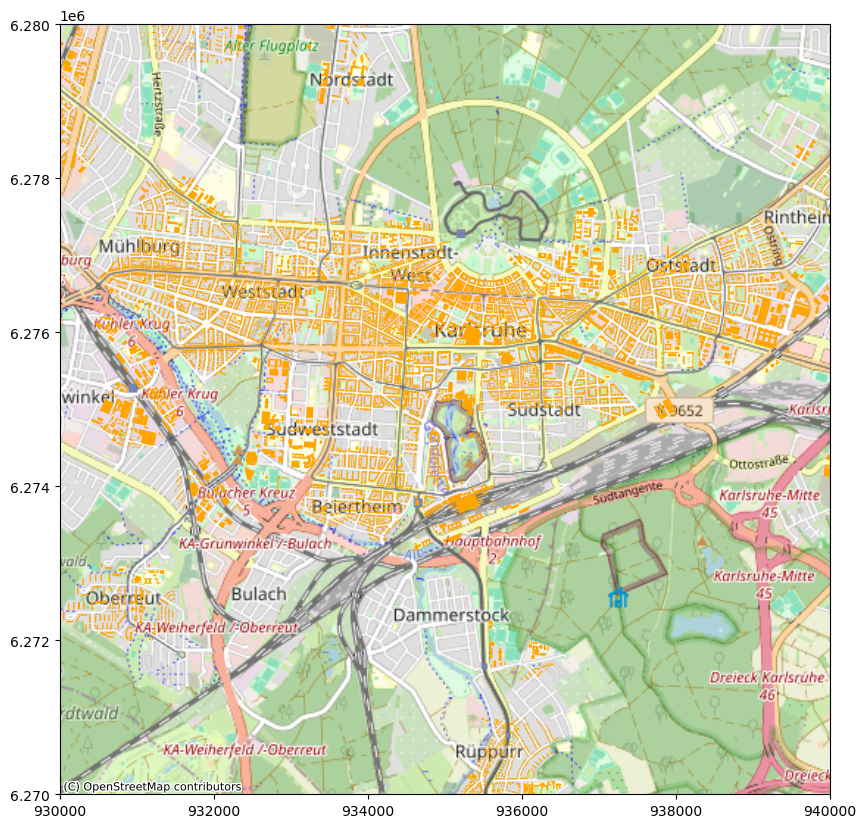

In [ ]:
xlim = ([0.930E6, 0.940E6])
ylim = ([6.270E6, 6.280E6])

fig, ax = plt.subplots(figsize=(10, 10))  # Create figure and axes

ax.set_ylim(ylim)
ax.set_xlim(xlim)

test_gdf.plot(ax=ax, color="orange")
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Show the plot
plt.show()

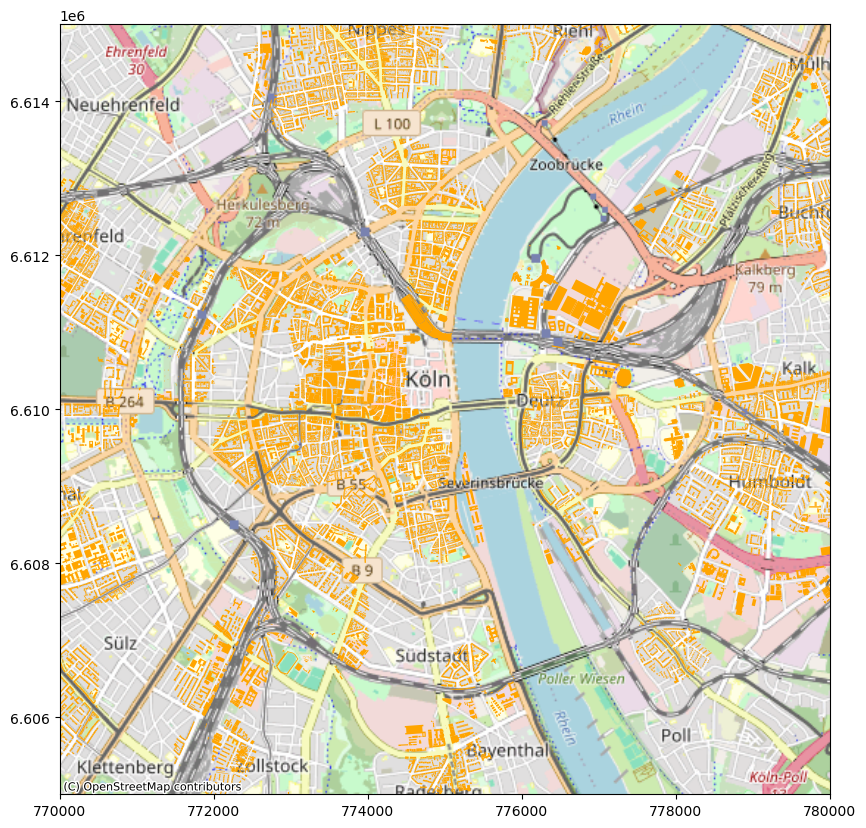

In [ ]:
xlim = ([0.7700E6, 0.780E6])
ylim = ([6.605E6, 6.615E6])

fig, ax = plt.subplots(figsize=(10, 10))  # Create figure and axes

ax.set_ylim(ylim)
ax.set_xlim(xlim)

test_gdf.plot(ax=ax, color="orange")
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()

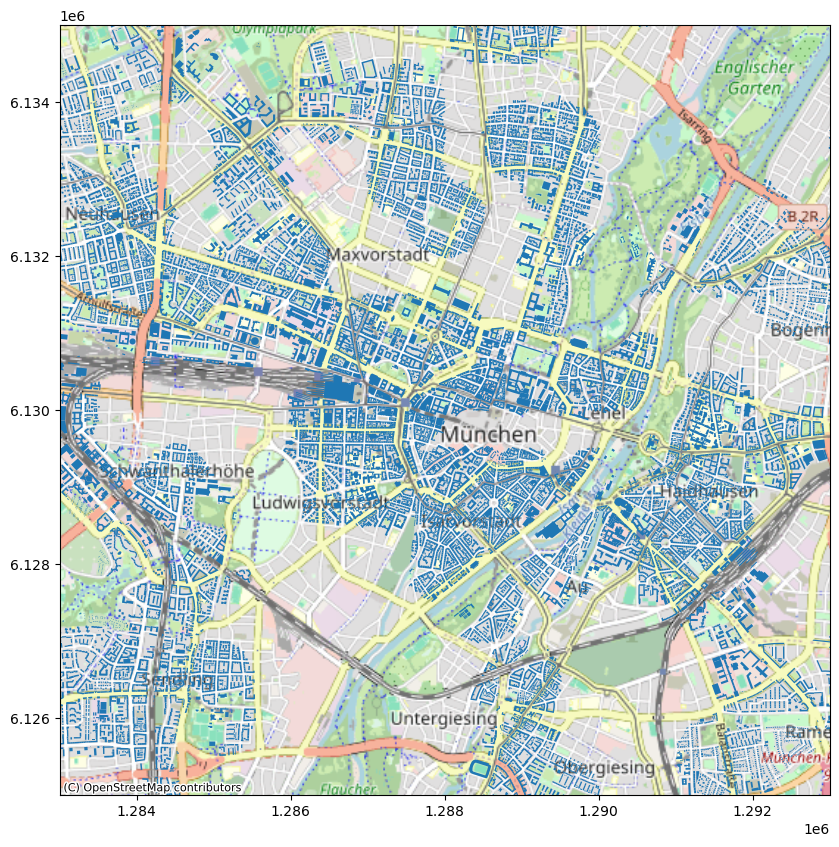

In [ ]:
xlim = ([1.283E6, 1.293E6])
ylim = ([6.125E6, 6.135E6])

fig, ax = plt.subplots(figsize=(10, 10))  # Create figure and axes

ax.set_ylim(ylim)
ax.set_xlim(xlim)

train_gdf.plot(ax=ax)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.show()

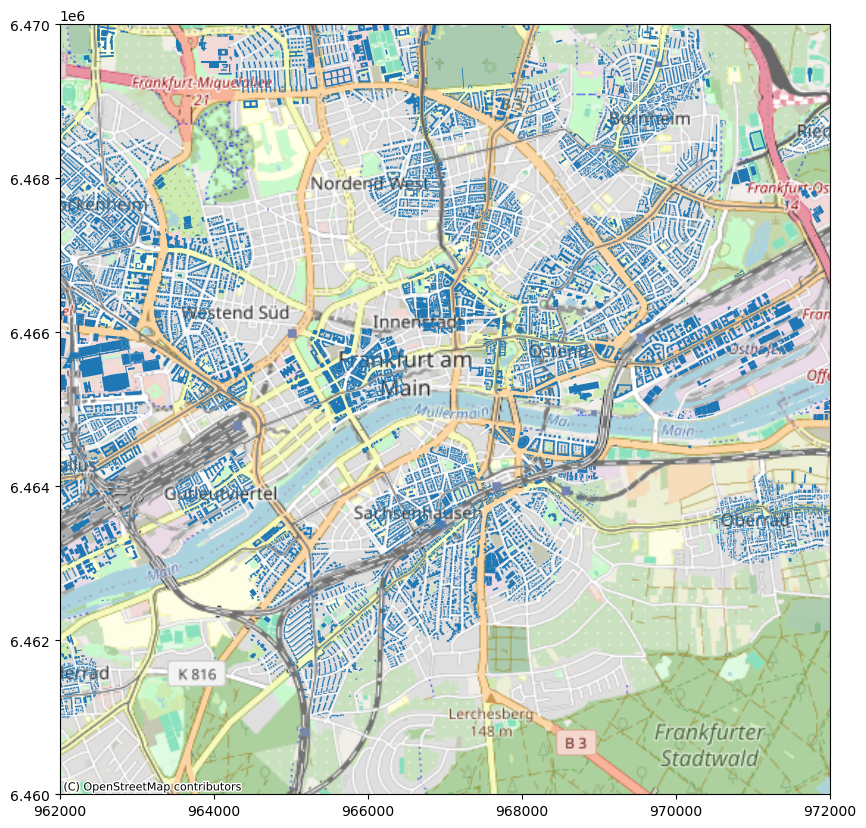

In [ ]:
xlim = ([0.962E6, 0.972E6])
ylim = ([6.460E6, 6.470E6])

fig, ax = plt.subplots(figsize=(10, 10))  # Create figure and axes

ax.set_ylim(ylim)
ax.set_xlim(xlim)

train_gdf.plot(ax=ax)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()

In [ ]:
amenity_count_model.to_csv("model2_address2_500.csv")

In [ ]:
amenity_count_model_j2.to_csv("model2_address2_j_500.csv")

In [ ]:
X_train, y_train = train_gdf.drop(columns=["osm_id","food_and_bev", "way","way_area_left","building", "building_count_gap", "centroid","way_area_right","index_right","name","random"]), train_gdf["food_and_bev"]
X_test, y_test = test_gdf.drop(columns=["osm_id","food_and_bev", "way","way_area_left","building", "building_count_gap", "centroid","way_area_right","index_right","name","random"]), test_gdf["food_and_bev"]

In [ ]:
X_train.shape

(1999387, 86)

In [ ]:
X_train.columns

Index(['amenity_count_500_atm', 'amenity_count_500_bicycle_parking',
       'amenity_count_500_pharmacy', 'amenity_count_500_parking_entrance',
       'amenity_count_500_charging_station', 'amenity_count_500_taxi',
       'amenity_count_500_bank', 'amenity_count_500_post_office',
       'amenity_count_500_theatre', 'amenity_count_500_nightclub',
       'amenity_count_500_school', 'amenity_count_500_events_venue',
       'amenity_count_500_cinema', 'amenity_count_500_marketplace',
       'railway_count_500_subway_entrance', 'railway_count_500_stop',
       'railway_count_500_tram_stop', 'railway_count_500_station',
       'railway_count_500_crossing', 'leisure_count_500_picnic_table',
       'leisure_count_500_playground', 'leisure_count_500_pitch',
       'leisure_count_500_sports_centre', 'leisure_count_500_fitness_centre',
       'leisure_count_500_fitness_station', 'leisure_count_500_swimming_pool',
       'building_count_500_apartments', 'building_count_500_residential',
       'bu

In [ ]:
X_test.shape

(849336, 86)

In [ ]:
xgbr = XGBRegressor(n_estimators = 100, max_depth = 5, random_state = 114)
xgbr.fit(X_train, y_train)

predictions = xgbr.predict(X_test)

r2 = r2_score(y_test, predictions)
r2

0.8266202788504353

In [ ]:
explainer = shap.Explainer(xgbr, X_train.sample(10000,random_state=111))
shap_values = explainer(X_train.sample(10000,random_state=111))

 95%|=================== | 9487/10000 [00:16<00:00]       

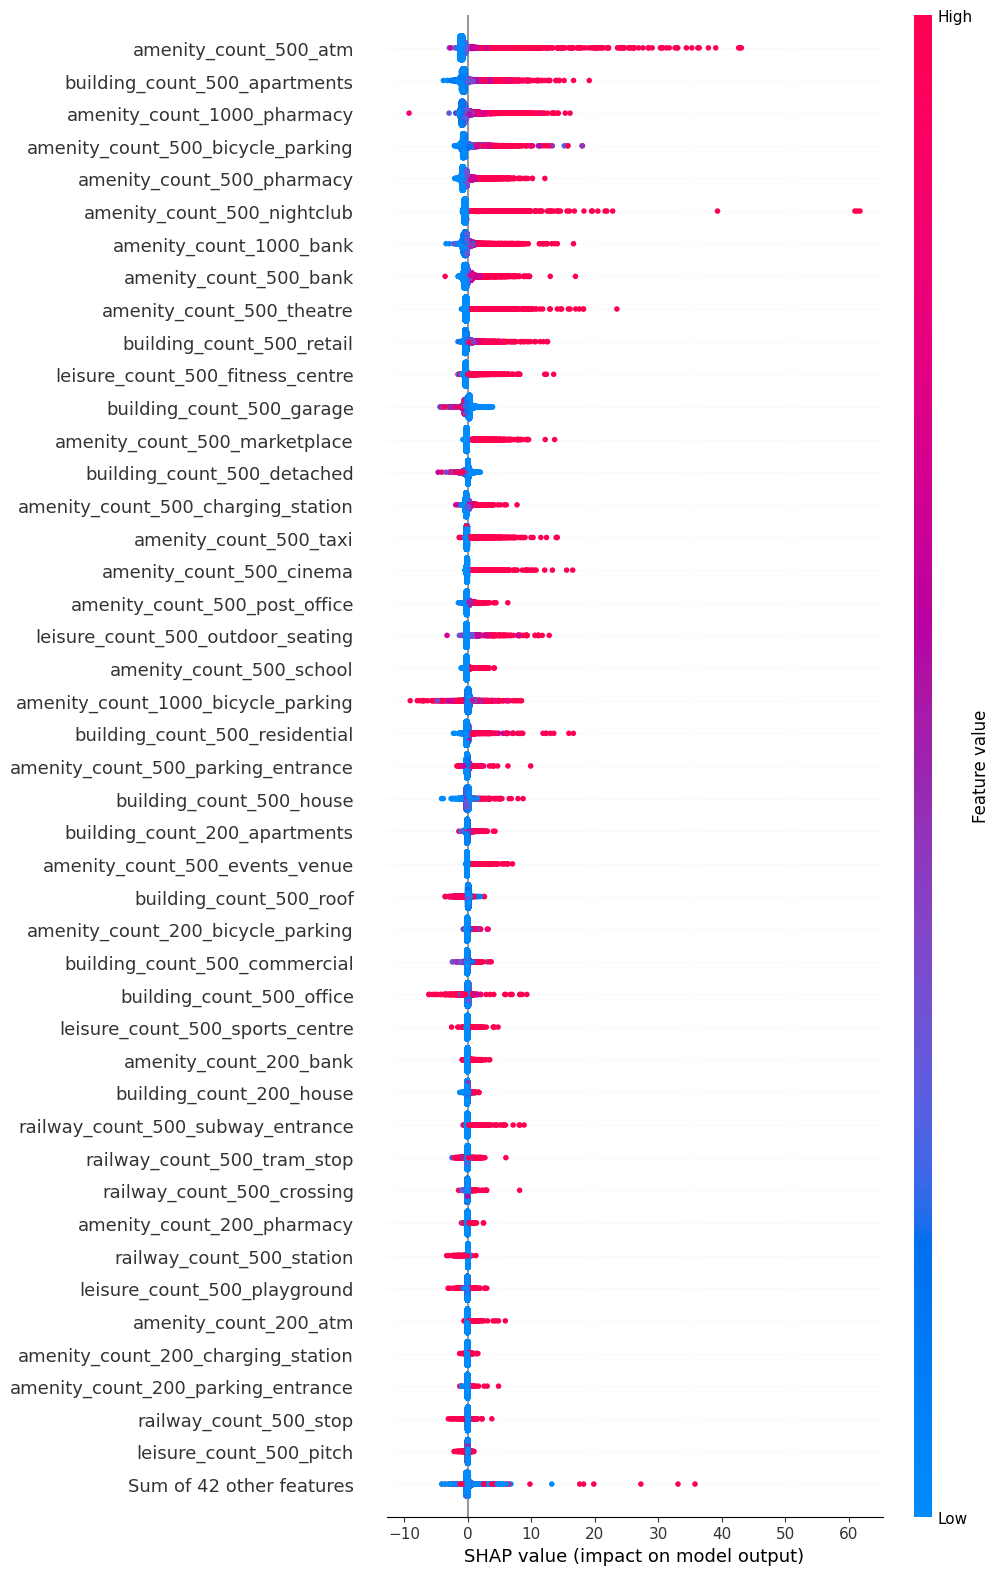

In [ ]:
shap.plots.beeswarm(shap_values, max_display=45)

*Considering the correlation between atms and out y variable, we will remove it from the dataset*

In [ ]:
import time

In [ ]:
X_train2, y_train2 = train_gdf.drop(columns=["amenity_count_500_atm","amenity_count_200_atm","osm_id","food_and_bev", "way","way_area_left","building", "building_count_gap", "centroid","way_area_right","index_right","name","random"]), train_gdf["food_and_bev"]
X_test2, y_test2 = test_gdf.drop(columns=["amenity_count_500_atm","amenity_count_200_atm","osm_id","food_and_bev", "way","way_area_left","building", "building_count_gap", "centroid","way_area_right","index_right","name","random"]), test_gdf["food_and_bev"]


In [ ]:
#we create a dataframe to store the accuracy and time to run each of the models
df_results = pd.DataFrame(columns=["model","r2_score", "time"])

In [ ]:
start_time = time.time()
xgbr = XGBRegressor(n_estimators = 100, max_depth = 5, random_state = 114)
xgbr.fit(X_train2, y_train2)

predictions = xgbr.predict(X_test2)

r2_m1 = r2_score(y_test2, predictions)
total_time_m1 =  (time.time() - start_time)
r2_m1


0.8034602495512234

In [ ]:
r2_m1

0.8034602495512234

In [ ]:
total_time_m1

13.685537099838257

In [ ]:
df_results.loc[len(df_results)] = ["XGBoost", r2_m1, total_time_m1]

In [ ]:
df_results

model  r2_score       time
0  XGBoost   0.80346  13.685537

In [ ]:
explainer = shap.Explainer(xgbr, X_train2.sample(10000,random_state=111))
shap_values = explainer(X_train2.sample(10000,random_state=111))

 97%|=================== | 9739/10000 [00:17<00:00]       

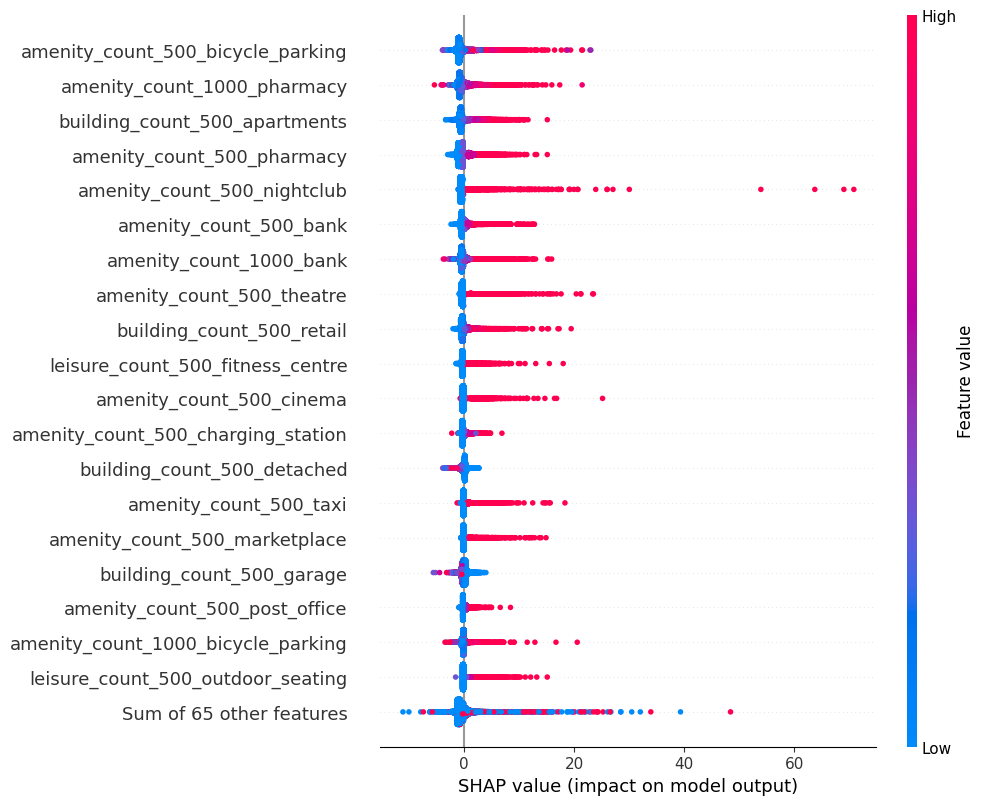

In [ ]:
shap.plots.beeswarm(shap_values, max_display=20)

In [ ]:
#we will try PCA
from sklearn.decomposition import PCA
covar_matrix = PCA(n_components = len(X_train2.columns))
covar_matrix.fit(X_train2)

PCA(n_components=84)

(-1.0, 10.0)

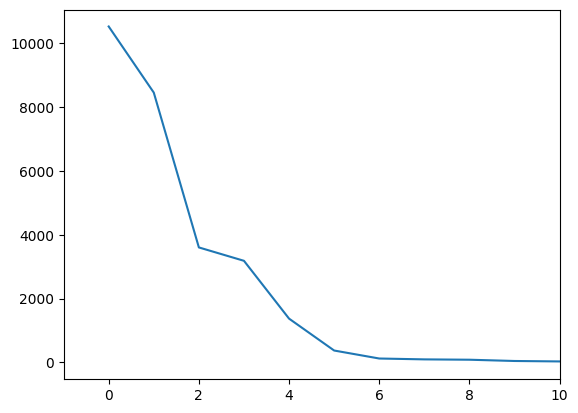

In [ ]:
plt.plot(covar_matrix.explained_variance_)
plt.xlim([-1,10])

(0.0, 100.0)

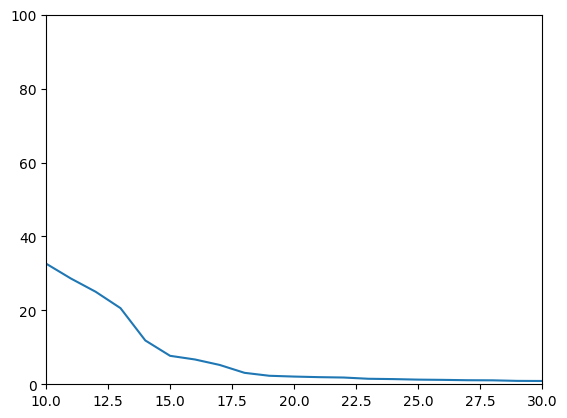

In [ ]:
plt.plot(covar_matrix.explained_variance_)
plt.xlim([10,30])
plt.ylim([0,100])

In [ ]:
pca = PCA(n_components = 20)
X_train2_pca = pca.fit_transform(X_train2)
X_test2_pca = pca.transform(X_test2)

In [ ]:
xgbr = XGBRegressor(n_estimators = 100, max_depth = 5, random_state = 114)
xgbr.fit(X_train2_pca, y_train2)

predictions = xgbr.predict(X_test2_pca)

r2 = r2_score(y_test2, predictions)

In [ ]:
r2

0.7163271749242253

*As the metrics get worse using pda, it will not be used in the rest of the models*

In [ ]:
!pip install verstack

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 62.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 103.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 95.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.7/155.7 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 88.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 86.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 51.8 M

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.1 MB/s eta 0:00:00


In [ ]:
from verstack import Stacker
from sklearn.linear_model import Ridge
#from sklearn.ensemble import GradientBoostingRegressor
#from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
#from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from lightgbm.sklearn import LGBMRegressor
from catboost import CatBoostRegressor

In [ ]:
start_time = time.time()
cbbr = CatBoostRegressor(loss_function='RMSE', max_depth=5)
cbbr.fit(X_train2, y_train2)

predictions = cbbr.predict(X_test2)

r2_m2 = r2_score(y_test2, predictions)
total_time_m2 =  (time.time() - start_time)


Learning rate set to 0.136057
0:	learn: 12.9128819	total: 242ms	remaining: 4m 1s
1:	learn: 11.9753499	total: 400ms	remaining: 3m 19s
2:	learn: 11.1708369	total: 568ms	remaining: 3m 8s
3:	learn: 10.5011833	total: 716ms	remaining: 2m 58s
4:	learn: 9.9173812	total: 883ms	remaining: 2m 55s
5:	learn: 9.4340128	total: 1.05s	remaining: 2m 54s
6:	learn: 9.0174930	total: 1.22s	remaining: 2m 52s
7:	learn: 8.6515594	total: 1.41s	remaining: 2m 54s
8:	learn: 8.3309917	total: 1.62s	remaining: 2m 58s
9:	learn: 8.0430938	total: 1.8s	remaining: 2m 58s
10:	learn: 7.7894371	total: 2s	remaining: 2m 59s
11:	learn: 7.5748402	total: 2.19s	remaining: 3m
12:	learn: 7.3858882	total: 2.39s	remaining: 3m 1s
13:	learn: 7.2217255	total: 2.6s	remaining: 3m 3s
14:	learn: 7.0796906	total: 2.76s	remaining: 3m 1s
15:	learn: 6.9446426	total: 2.95s	remaining: 3m 1s
16:	learn: 6.8296249	total: 3.14s	remaining: 3m 1s
17:	learn: 6.7303503	total: 3.3s	remaining: 2m 59s
18:	learn: 6.6389045	total: 3.51s	remaining: 3m 1s
19:	le

In [ ]:
r2_m2

0.8356106206215286

In [ ]:
df_results.loc[len(df_results)] = ["Catboost", r2_m2, total_time_m2]

In [ ]:
df_results

model  r2_score        time
0   XGBoost  0.803460   13.685537
1  Catboost  0.835611  151.427591

In [ ]:
#explainer = shap.Explainer(cbbr, X_train2.sample(10000,random_state=111))
explainer = shap.TreeExplainer(cbbr)
shap_values = explainer(X_train2.sample(10000,random_state=111))

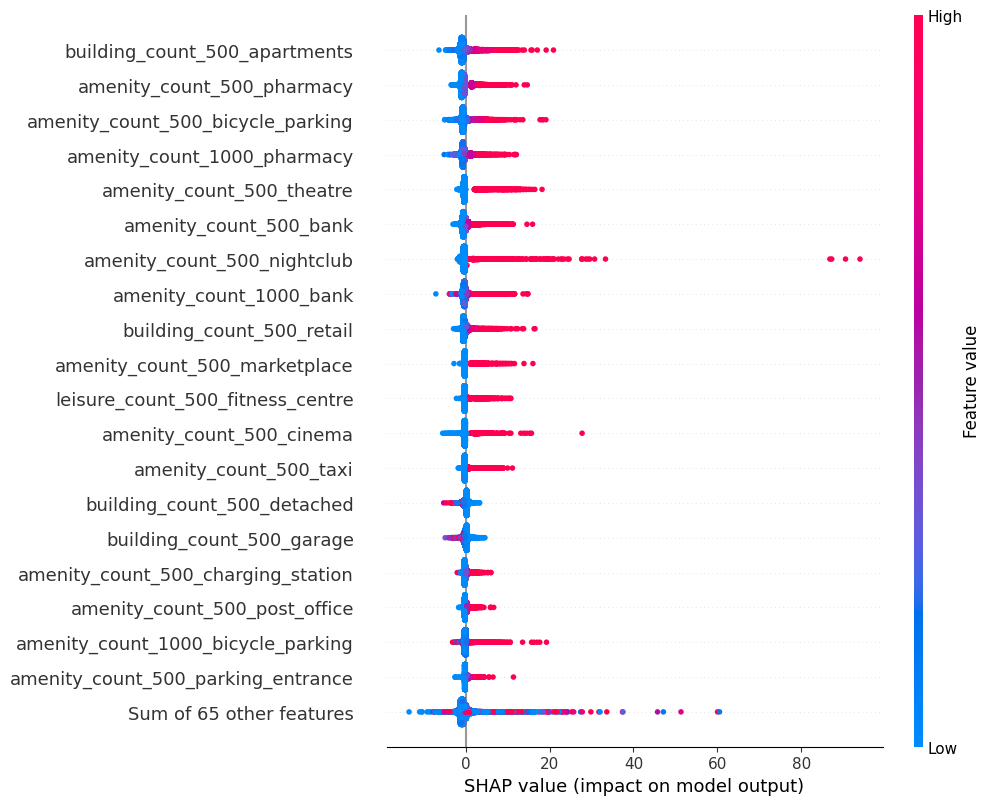

In [ ]:
shap.plots.beeswarm(shap_values, max_display=20)

In [ ]:
dataset_predict = amenity_count_model_j2.drop(columns=["amenity_count_500_atm","amenity_count_200_atm","osm_id","food_and_bev", "way","way_area_left","building", "building_count_gap", "centroid","way_area_right","index_right","name","random"])


In [ ]:
pred_final = cbbr.predict(dataset_predict)

In [ ]:
df = amenity_count_model_j2.copy()

In [ ]:
df["prediction"] = pred_final
df["food_and_bev"] = amenity_count_model_j2["food_and_bev"]

In [ ]:
df["gap"] = df["prediction"] - df["food_and_bev"]

In [ ]:
path_parent = os.path.dirname(os.getcwd())

In [ ]:
df_states = pd.read_csv('drive/MyDrive/CCP/germany_states.csv').drop(columns="Unnamed: 0")
df_states['way'] = df_states['way'].apply(wkt.loads)

In [ ]:
gdf_states = gpd.GeoDataFrame(df_states.drop(columns=["admin_level","boundary","place","ref", "centroid_way","centroid","way_area","osm_id"]), crs='epsg:3857', geometry="way")

In [ ]:
gdf_states.head()

name                                                way
0  Baden-Württemberg  POLYGON ((836203.751 6056721.852, 836208.883 6...
1             Bayern  POLYGON ((1163782.926 6033270.788, 1163921.820...
2             Berlin  POLYGON ((1456987.901 6876358.952, 1457195.356...
3        Brandenburg  POLYGON ((1254150.742 7005605.631, 1254325.313...
4             Bremen  POLYGON ((944166.603 7024997.466, 944222.363 7...

In [ ]:
df=df.drop(columns="index_right")
df2 = gpd.sjoin(df, gdf_states, how="left", op="within")

In [ ]:
df2.head()

osm_id    building  way_area_left  building_count_gap  \
0  233435192         yes       350.8180                   3   
1  129361696         yes       310.4870                   3   
2  617819875  apartments       753.5770                   1   
3  341604378       house       150.9630                   1   
4  243447826        shed        19.6007                   2   

                                                 way  amenity_count_500_atm  \
0  POLYGON ((1162141.665 7020590.227, 1162149.624...                      1   
1  POLYGON ((1111543.250 7068875.428, 1111561.139...                      3   
2  POLYGON ((1097095.594 6878481.293, 1097121.565...                      0   
3  POLYGON ((1245727.096 7168399.461, 1245733.920...                      0   
4  POLYGON ((1122488.048 7087350.230, 1122489.384...                      0   

   amenity_count_500_bicycle_parking  amenity_count_500_pharmacy  \
0                                  0                           1   
1                                 14                           3   
2                                  0                           2   
3                                  0                           0   
4                                  0                           0   

   amenity_count_500_parking_entrance  amenity_count_500_charging_station  \
0                                   0                                   0   
1                                  11                                   5   
2                                   0                                   0   
3                                   0                                   0   
4                                   0                                   0   

   ...  amenity_count_1000_bank  amenity_count_1000_bicycle_parking  \
0  ...                        0                                   0   
1  ...                       11                                  55   
2  ...                        2                                   1   
3  ...                        0                                   0   
4  ...                        0                                   1   

   food_and_bev            name_left  way_area_right  random  prediction  \
0             0             Lüneburg    3.693090e+09       1    0.695127   
1            18              missing             NaN       1   35.514688   
2             3      Region Hannover    6.164910e+09       1    4.058955   
3             0  Nordwestmecklenburg    5.989400e+09       0   -0.348271   
4             1              missing             NaN       1   -0.095550   

         gap  index_right              name_right  
0   0.695127          8.0           Niedersachsen  
1  17.514688          5.0                 Hamburg  
2   1.058955          8.0           Niedersachsen  
3  -0.348271          7.0  Mecklenburg-Vorpommern  
4  -1.095550          5.0                 Hamburg  

[5 rows x 100 columns]

In [ ]:
df2.to_csv("drive/MyDrive/CCP/df_gap_m2_full.csv",index=False)

In [ ]:
df2[["osm_id","way","building_count_gap","food_and_bev","prediction","gap","name_left","name_right"]].to_csv("drive/MyDrive/CCP/df_address_gap_m2_streamlit.csv", index=False)


In [ ]:
df2 = df2[df2["gap"]>1]

In [ ]:
df2[["osm_id","way","building_count_gap","food_and_bev","prediction","gap","name_left","name_right"]].to_csv("drive/MyDrive/CCP/df_address_gap_m2_streamlit_mayor1.csv")

In [ ]:
y_train2_st = y_train2.reset_index(drop=True)
y_test2_st = y_test2.reset_index(drop=True)

In [ ]:
stacker_mod = Stacker(objective = 'regression',
                  auto = False,
                  stacking_feats_depth = 2,
                  include_X = True,
                  )


stacker_mod.add_layer([
  XGBRegressor(n_estimators = 60, max_depth = 4, n_jobs = -1)
, XGBRegressor(max_depth = 5, n_jobs = -1)
, CatBoostRegressor(loss_function='RMSE', max_depth=5)

, LGBMRegressor(max_depth=6, n_jobs=-1)
])
stacker_mod.add_layer([
  DecisionTreeRegressor(max_depth = 6)
, Ridge()])

In [ ]:
start_time = time.time()
X_st = stacker_mod.fit_transform(X_train2, y_train2_st)
X_test_st = stacker_mod.transform(X_test2)
total_time_m3 =  (time.time() - start_time)

Streaming output truncated to the last 5000 lines.
613:	learn: 3.7190273	total: 58.5s	remaining: 36.8s
614:	learn: 3.7181454	total: 58.6s	remaining: 36.7s
615:	learn: 3.7169163	total: 58.7s	remaining: 36.6s
616:	learn: 3.7159175	total: 58.8s	remaining: 36.5s
617:	learn: 3.7149743	total: 58.9s	remaining: 36.4s
618:	learn: 3.7138148	total: 58.9s	remaining: 36.3s
619:	learn: 3.7121166	total: 59s	remaining: 36.2s
620:	learn: 3.7111877	total: 59.1s	remaining: 36.1s
621:	learn: 3.7096935	total: 59.2s	remaining: 36s
622:	learn: 3.7088026	total: 59.3s	remaining: 35.9s
623:	learn: 3.7081387	total: 59.4s	remaining: 35.8s
624:	learn: 3.7070366	total: 59.4s	remaining: 35.7s
625:	learn: 3.7063629	total: 59.5s	remaining: 35.6s
626:	learn: 3.7049109	total: 59.6s	remaining: 35.5s
627:	learn: 3.7040188	total: 59.7s	remaining: 35.4s
628:	learn: 3.7030637	total: 59.8s	remaining: 35.3s
629:	learn: 3.7017220	total: 59.9s	remaining: 35.2s
630:	learn: 3.7009395	total: 60s	remaining: 35.1s
631:	learn: 3.70001

In [ ]:
model = Ridge()
layer_1_feats = stacker_mod.stacked_features['layer_1']
layer_2_feats = stacker_mod.stacked_features['layer_2']

model.fit(X_st[layer_1_feats + layer_2_feats], y_train2_st)
pred2 = model.predict(X_test_st[layer_1_feats + layer_2_feats])
r2_m3 = r2_score(y_test2_st, pred2)
r2_m3

0.8347827608625868

In [ ]:
total_time_m3


2251.299579143524

In [ ]:
df_results.loc[len(df_results)] = ["Stacker", r2_m3, total_time_m3]

In [ ]:
#divide the test dataset in test and validation
X_test3, X_val,  y_test3, y_val = train_test_split(X_test2, y_test2, test_size = 0.5, random_state = 101)

In [ ]:
#we apply standarscaler
scaler = StandardScaler()
X_train_nor =  scaler.fit_transform(X_train2)
X_test_nor =  scaler.transform(X_test3)
X_val_nor =  scaler.transform(X_val)

In [ ]:
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

In [ ]:
start_time = time.time()
hidden_size = 100
number_hidden_units1 = 256
data_rows_number = X_train2.shape[0]
data_columns_number = X_train2.shape[1]
inputs = Input(shape=(data_columns_number,))
layer1 = Dense(number_hidden_units1, activation = "softmax")(inputs)
dropout1 = Dropout(0.2)(layer1)  # Add dropout layer with 0.2 dropout rate
layer2 = Dense(number_hidden_units1, activation = "relu")(dropout1)
dropout2 = Dropout(0.2)(layer2)  # Add dropout layer with 0.2 dropout rate
output = Dense(1, activation="linear")(dropout2)

model = Model(inputs=inputs, outputs=output)
model.compile(optimizer="Adam",
              loss='mean_squared_error', # use this cross entropy variant
              # since the input is not one-hot encoded
              metrics=['mean_squared_error']) #We measure and print accuracy during training

history = model.fit(
    X_train2, y_train2, epochs=20, batch_size=100, verbose=0, validation_data=(X_test3, y_test3))
total_time_m4 =  (time.time() - start_time)

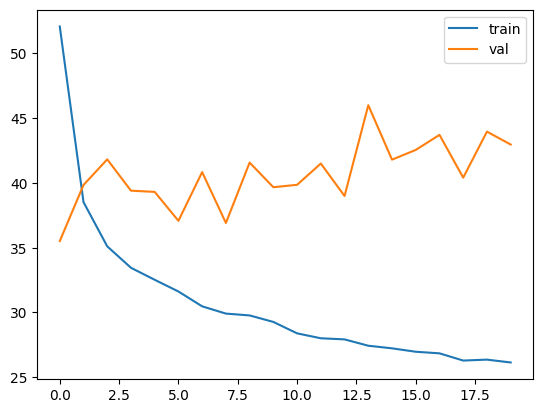

In [ ]:
plt.plot(history.history["mean_squared_error"], label="train")
plt.plot(history.history["val_mean_squared_error"], label="val")
plt.legend()

In [ ]:
predictions = model.predict(X_test3)#.round(0)
r2_m4 = r2_score(y_test3, predictions)
r2_m4

13271/13271 [==============================] - 19s 1ms/step


0.7329508519377907

In [ ]:
df_results.loc[len(df_results)] = ["Neural Network", r2_m4, total_time_m4]

In [ ]:
from tensorflow.keras.layers import LSTM, Flatten

In [ ]:
start_time = time.time()

hidden_size = 100
number_hidden_units1 = 256
data_rows_number = X_train_nor.shape[0]
data_columns_number = X_train_nor.shape[1]
inputs = Input(shape=(None, data_columns_number))  # 'None' for variable sequence length
lstm_layer1 = LSTM(number_hidden_units1, activation="softmax", return_sequences=True)(inputs)
dropout1 = Dropout(0.2)(lstm_layer1)
lstm_layer2 = LSTM(number_hidden_units1, activation="relu")(dropout1)
dropout2 = Dropout(0.2)(lstm_layer2)
flatten_layer = Flatten()(dropout2)
output = Dense(1, activation="linear")(flatten_layer)


model = Model(inputs=inputs, outputs=output)
model.compile(optimizer="Adam",
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

history = model.fit(
    X_train_nor[:, None, :], y_train2, epochs=10, batch_size=50, verbose=0, validation_data=(X_test_nor[:, None, :], y_test3))
total_time_m5 =  (time.time() - start_time)


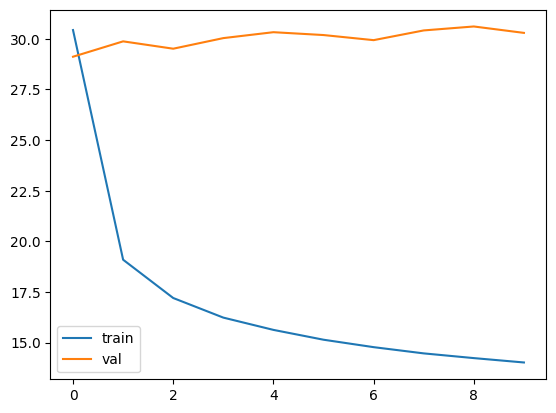

In [ ]:
plt.plot(history.history["mean_squared_error"], label="train")
plt.plot(history.history["val_mean_squared_error"], label="val")
plt.legend()

In [ ]:
predictions = model.predict(X_val_nor[:, None, :])
r2_m5 = r2_score(y_val, predictions)
r2_m5

13271/13271 [==============================] - 36s 3ms/step


0.8124210364892646

In [ ]:
start_time = time.time()

hidden_size = 100
number_hidden_units1 = 256
data_rows_number = X_train_nor.shape[0]
data_columns_number = X_train_nor.shape[1]
inputs = Input(shape=(None, data_columns_number))  # 'None' for variable sequence length
lstm_layer1 = LSTM(number_hidden_units1, activation="softmax", return_sequences=True)(inputs)
dropout1 = Dropout(0.2)(lstm_layer1)
lstm_layer2 = LSTM(number_hidden_units1, activation="relu")(dropout1)
dropout2 = Dropout(0.2)(lstm_layer2)
flatten_layer = Flatten()(dropout2)
output = Dense(1, activation="linear")(flatten_layer)


model = Model(inputs=inputs, outputs=output)
model.compile(optimizer="Adam",
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

history = model.fit(
    X_train_nor[:, None, :], y_train2, epochs=10, batch_size=100, verbose=0, validation_data=(X_test_nor[:, None, :], y_test3))
total_time_m5 =  (time.time() - start_time)


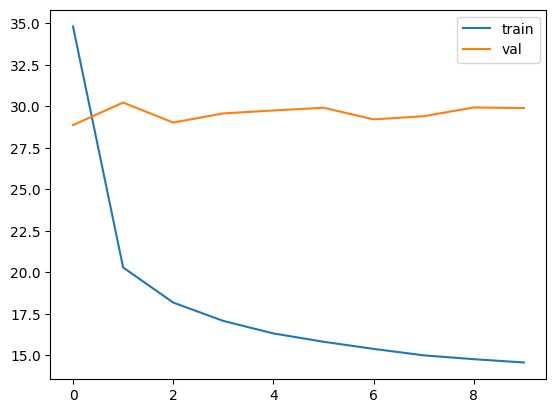

In [ ]:
plt.plot(history.history["mean_squared_error"], label="train")
plt.plot(history.history["val_mean_squared_error"], label="val")
plt.legend()

In [ ]:
predictions = model.predict(X_val_nor[:, None, :])
r2_m5 = r2_score(y_val, predictions)
r2_m5

13271/13271 [==============================] - 38s 3ms/step


0.8135497684299883

In [ ]:
df_results.loc[len(df_results)] = ["LSTM", r2_m5, total_time_m5]

In [ ]:
df_results = df_results.sort_values(by="r2_score")

In [ ]:
df_results.to_csv("drive/MyDrive/CCP/df_results2.csv")

In [ ]:
df_results

model  r2_score         time
0  Neural Network  0.732951  1339.733206
1         XGBoost  0.803460    13.685537
2            LSTM  0.812421  3380.685718
3         Stacker  0.834783  2251.299579
4        Catboost  0.835611   151.427591

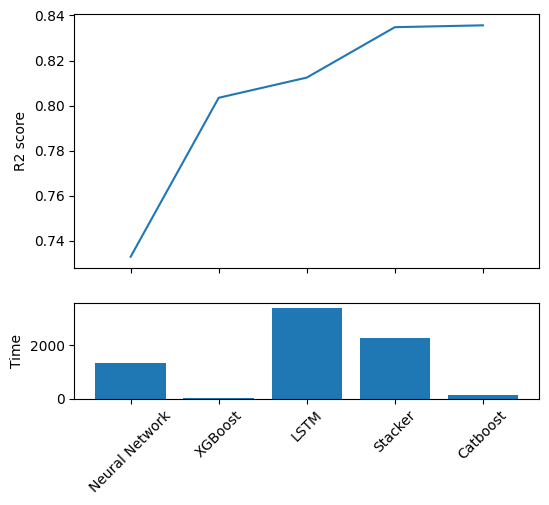

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(6,5),  sharex=True, gridspec_kw={'height_ratios': [8, 3]})

ax[0].plot(df_results["model"],df_results["r2_score"])
ax[0].set_ylabel("R2 score")
ax[1].bar(df_results["model"],df_results["time"])
ax[1].set_ylabel("Time")
#ax[1].spines[['right', 'top','left']].set_visible(False)
ax[1].tick_params(axis='x', rotation=45)
#ax.xticks(rotation=60)
#ax.title("R2 score by model")
#ax.ylabel("R2 score")
#ax.xlabel("Model")
plt.show()

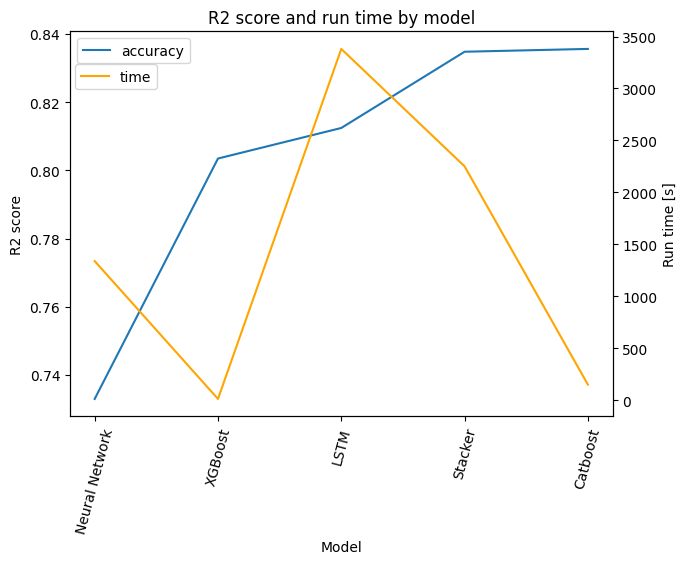

In [ ]:
#we plot the results for r2 score and run time
plt.figure(figsize=(7,5))
sns.lineplot(data=df_results.sort_values(by="r2_score"), x="model", y="r2_score", label="accuracy")
plt.xticks(rotation=75)
plt.legend(loc = 'upper left')
plt.ylabel("R2 score")
plt.xlabel("Model")
ax2 = plt.twinx()
sns.lineplot(data=df_results.sort_values(by="r2_score"), ax=ax2,x="model", y="time", label="time", color="orange")
plt.legend(loc = (0.01,0.85))
plt.title("R2 score and run time by model")
ax2.set_ylabel("Run time [s]")
plt.show()